# Credit Card Fraud Detections using transactional data
By

Ajey Musuwathi Rajkumar

Charan Rajagopal

Vivek Nagarajan

Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report,plot_roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks,RandomUnderSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# import xgboost as xgb

## 1. Loading the data

In [4]:
lines = []
with open('codetest_train.txt') as f:
    lines = f.readlines()
dic_list = []    
count = 0
for line in lines:
    dic = json.loads(line)
    dic_list.append(dic)

df = pd.DataFrame(dic_list)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

#### Understanding the data types and basic statistics of the columns in the imported dataframe

In [82]:
print('The count of the number of datapoints in the data are', df.shape[0])

The count of the number of datapoints in the data are 786363


In [83]:
df.dtypes

accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

In [84]:
df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


#### As seen above we have very few columns with numerical datatype and all other columns belong to the categorical type.

In [85]:
df = df.replace(r'^\s*$', np.nan, regex=True)
df.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

Here I can see that dataframe some colunmns that are not in the correct datatype such as the transactionDateTime and there are many columns that are completely empty so here are some basic cleaning that was done, 
1. Reformatting the transactionDateTime columns to indicate the datetime format
2. Creating a new column named matching CVV that says if the cvv and entered cvv matched correctly
2. Dropping empty columns
3. Replacing empty cells with Nan with Median / Mean for categorical and continuous variable respectively

In [86]:
df['transactionDateTime'] = df['transactionDateTime'].str.replace('T',' ')
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], format ='%Y-%m-%d %H:%M:%S')
df['date'] = df['transactionDateTime'].dt.date

In [87]:
df['matchingCVV'] = df['cardCVV'] == df['enteredCVV']

In [88]:
df['reversal_duplicates'] = df.duplicated(subset = ['accountNumber','transactionAmount','merchantName','date','cardLast4Digits'])

In [89]:
df['multiple_swipe_duplicates'] = df.sort_values(['transactionDateTime']).groupby(['customerId', 'transactionAmount'], sort=False)['transactionDateTime'].diff().dt.total_seconds().lt(120)

#### Dropping columns

In [90]:
df['posEntryMode'] = df['posEntryMode'].fillna(value = df['posEntryMode'].median())
df['posConditionCode'] = df['posConditionCode'].fillna(value = df['posConditionCode'].median())
df['acqCountry'] = df['acqCountry'].fillna(value = 'US')
df['merchantCountryCode'] = df['merchantCountryCode'].fillna(value = 'US')

## 2. Data Visualization and Plotting 

Plotting all the countinous variables in a histogram to analyze the structure of the data and check for any data skewness. From the histogram plot it can be observed there does not seem to be any significant data skewness that is present that needs correction.

If there is any data skewness then we can use the PowerTransformer function to remove any skewness that might be present in the data.

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<AxesSubplot:xlabel='currentBalance', ylabel='Density'>

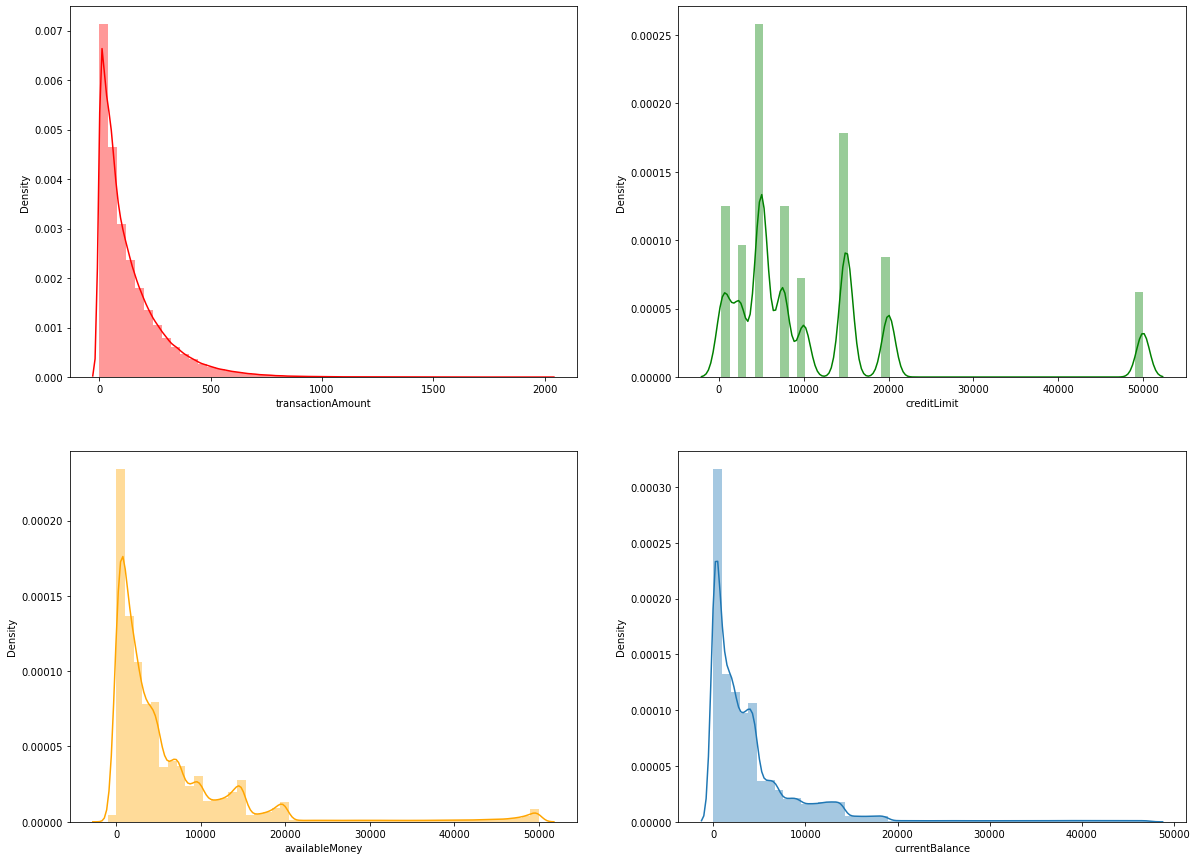

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

sns.distplot(df['transactionAmount'], ax = ax[0][0], color = 'Red')
sns.distplot(df['creditLimit'], ax = ax[0][1], color = 'Green')
sns.distplot(df['availableMoney'], ax = ax[1][0], color = 'Orange')
sns.distplot(df['currentBalance'], ax = ax[1][1])

Using a boxplot to understand and see of there is any significant relationship between the transaction amount and whether or not the transaction is fraud or not. From the plot below it can observed that the fraud amount is a little higher than the average transaction amount of nonfraud transactions but it is not very significantly higher. 

Text(0, 0.5, 'Transaction Amount')

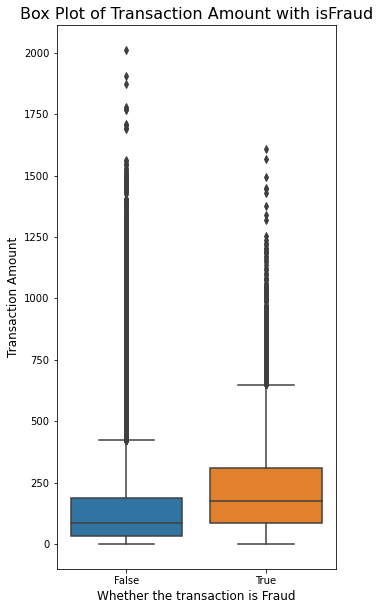

In [92]:
plt.figure(figsize = (5,10))
ax = sns.boxplot(x = df['isFraud'], y = df['transactionAmount'])
ax.axes.set_title('Box Plot of Transaction Amount with isFraud', fontsize = 16)
ax.set_xlabel('Whether the transaction is Fraud', fontsize = 12)
ax.set_ylabel('Transaction Amount', fontsize = 12)

Using a countplot to see if the fraud transaction are more prevalent when the wrong cvv number is entered. But from the plot it can be see that ver y few transactions with the wrongly entered cvv were classified as fraud.

Text(0.5, 1.0, 'Relationship between Matching CVV and Fraudulent Transactions')

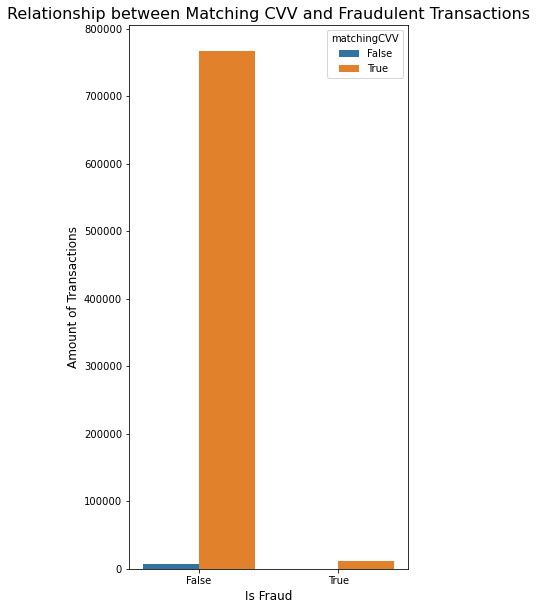

In [93]:
plt.figure(figsize = (5,10))
sns.countplot(data=df, x='isFraud', hue='matchingCVV')
plt.xlabel('Is Fraud',fontsize = 12)
plt.ylabel('Amount of Transactions',fontsize = 12)
plt.title('Relationship between Matching CVV and Fraudulent Transactions', fontsize = 16)

Text(0.5, 1.0, 'Relationship between Card Present Transactions and Fraudulent Transactions')

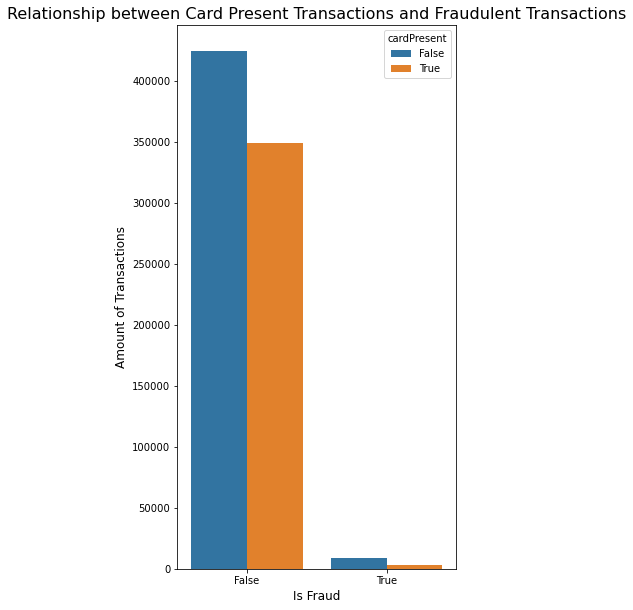

In [94]:
plt.figure(figsize = (5,10))
sns.countplot(data=df, x='isFraud', hue='cardPresent')
plt.xlabel('Is Fraud',fontsize = 12)
plt.ylabel('Amount of Transactions',fontsize = 12)
plt.title('Relationship between Card Present Transactions and Fraudulent Transactions', fontsize = 16)

## 3. Data Wrangling - Duplicate Transactions

#### Reversal Transaction: 
Reversal transactions are transactions when a sale is cancelled from the customer side or the sale is cancelled due to some techincal difficulties at the receivers end and the debited amount is credited back to the customer's account.

There is a column in the dataframe named Transaction Type that indicates the type of transaction it was such as Purchase, Address verification, or Reversal. This can be used as the basic way to calculate the number of reversal transaction. The results from using this are as follows,

In [95]:
print(Counter(df['transactionType']))

Counter({'PURCHASE': 745193, 'REVERSAL': 20303, 'ADDRESS_VERIFICATION': 20169, nan: 698})


#### Reversal Transaction:
In addition to the transactions classified as REVERSAL there are 7820 transaction that have been identified to be potentially reversal transaction classified otherwise. 
* In total there are an estimated 28123 reversal transaction.

In [96]:
# needs to be run before the columns are droped in the above cells 
df['reversal_duplicates'] = df[df['transactionType'] != 'REVERSAL'].duplicated(subset = ['accountNumber','transactionAmount','merchantName','date','cardLast4Digits'])
df['reversal_duplicates'].mask(df['transactionType'] == 'REVERSAL' ,other = True, inplace = True)

In [97]:
print('The total number of estimated reversal transactions are',df['reversal_duplicates'].sum())

The total number of estimated reversal transactions are 28123


#### Multipleswipe Transaction:
Multiswipe transactions are when the customer is debited twice by accident and is only noticed at a later stage and needs to be handled with the credit card company

The multipleswipe transactions was estimated with the following logic, if the same customer was charged the same amount on the same card within a short span of 2 minutes it was considered multiple swipe transactions

In [98]:
# needs to be run before the columns are droped in the above cells 
df['multiple_swipe_duplicates'] = df.sort_values(['transactionDateTime']).groupby(['customerId', 'transactionAmount','cardLast4Digits'], sort=False)['transactionDateTime'].diff().dt.total_seconds().lt(120)

In [99]:
print('The total number of multiple swipe transactions are estimated to be', df['multiple_swipe_duplicates'].sum())

The total number of multiple swipe transactions are estimated to be 8882


Text(0.5, 1.0, 'Relationship between Multiple swipe transactions and Fraudulant Transactions')

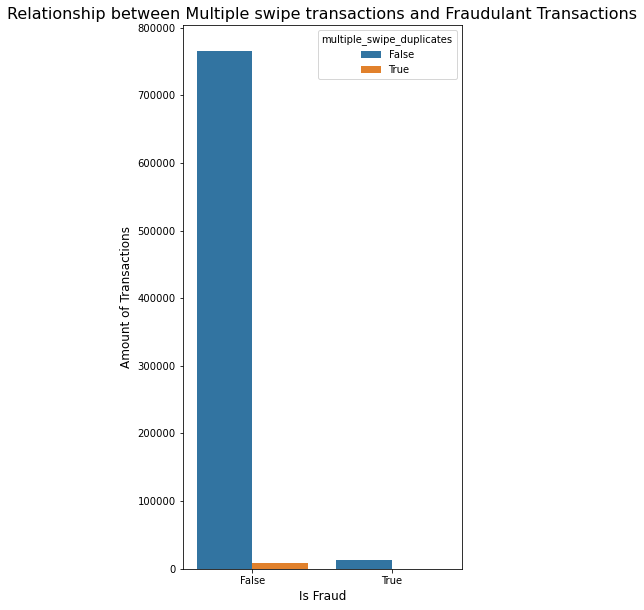

In [100]:
plt.figure(figsize = (5,10))
sns.countplot(data=df, x='isFraud', hue = 'multiple_swipe_duplicates')
plt.xlabel('Is Fraud',fontsize = 12)
plt.ylabel('Amount of Transactions',fontsize = 12)
plt.title('Relationship between Multiple swipe transactions and Fraudulant Transactions', fontsize = 16)

Text(0.5, 1.0, 'Relationship between Multiple swipe transactions and Fraudulant Transactions')

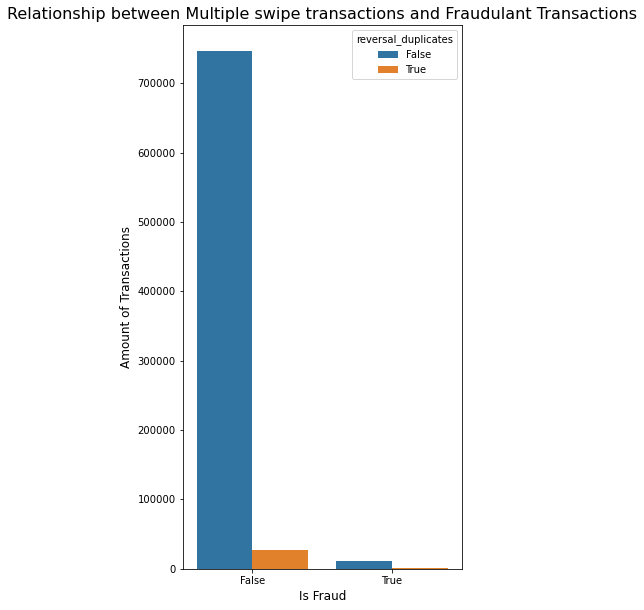

In [101]:
plt.figure(figsize = (5,10))
sns.countplot(data=df, x='isFraud', hue = 'reversal_duplicates')
plt.xlabel('Is Fraud',fontsize = 12)
plt.ylabel('Amount of Transactions',fontsize = 12)
plt.title('Relationship between Multiple swipe transactions and Fraudulant Transactions', fontsize = 16)

#### Interesting insight: 
It can be observed that there are very little to no fraudulant transactions that are happening in the reversal and multiple swipe transactions.

## 4. Model

As a part of the preporcessing the following steps were carried out,
1. The categorical columns were one hot encoded
2. Some addtional columns were engineered from the transactionDateTime column to add more features related to transaction date and time.
3. All the unecessary columns are dropped
4. The X and y are created
5. All the columns are scaled using Standard Scaler

In [102]:
df['isFraud'] = df['isFraud'].replace({False: 0, True: 1})
df = pd.get_dummies(df, columns = ['acqCountry','merchantCountryCode','merchantCategoryCode','transactionType','cardPresent','expirationDateKeyInMatch','matchingCVV','reversal_duplicates','multiple_swipe_duplicates'])

In [103]:
df['transactionDateTime_year'] = df['transactionDateTime'].dt.year
df['transactionDateTime_month'] = df['transactionDateTime'].dt.month
df['transactionDateTime_week'] = df['transactionDateTime'].dt.week
df['transactionDateTime_day'] = df['transactionDateTime'].dt.day
df['transactionDateTime_hour'] = df['transactionDateTime'].dt.hour
df['transactionDateTime_minute'] = df['transactionDateTime'].dt.minute
df['transactionDateTime_dayofweek'] = df['transactionDateTime'].dt.dayofweek

<ipython-input-103-0ef115d65bab>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['transactionDateTime_week'] = df['transactionDateTime'].dt.week


In [104]:
# dropping empty columns
# better to perform this step in the section 4
df.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'], axis = 1, inplace = True)

In [105]:
# dropping columns with categorical variable that does not provide meaningful information
# dropping columns which cannot be one hot encoded due to the presence of a large number of unique variable
# better to perform this step in the section 4
df.drop(['transactionDateTime','merchantName','currentExpDate','accountOpenDate','dateOfLastAddressChange','cardCVV','enteredCVV','cardLast4Digits','date'], axis = 1, inplace = True)

In [106]:
X = df.drop(columns = ['isFraud'])
y = df['isFraud']

In [107]:
scaler = preprocessing.StandardScaler().fit(X)
X_transformed = scaler.transform(X)

#### Handling Data imbalance:
There are many ways to handle imbalanced, some of the most popular ways include some sort of undersampling or oversampling. For this data I have chosen to use the random under sampler as it is the fastest and computing less expensive to carry out quiickly.

Some of the other methods that I was planning to try was Tomek Links under sampling but it was computational very time consuming to compute the resample and the other was the SMOTE oversampling. Eventhough the SMOTE oversampling was quicker to resample the large number of datapoints proved to be too large to carry out hyper parameter tuning with different models.

In [108]:
rus = RandomUnderSampler(random_state = 42)
X_transformed_balanced, y_balanced = rus.fit_resample(X_transformed,y)

In [109]:
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_balanced))

Original dataset shape Counter({0: 773946, 1: 12417})
Resampled dataset shape Counter({0: 12417, 1: 12417})


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed_balanced, y_balanced, test_size = 0.2, random_state = 42)

It can be seen that the number of samples have been reduced from 773946 to 12417. Now that we have a balanced dataset we can train a model to predict fraudulant transaction which are not a minority in nature.

### Random Forests

In [112]:
rf_parameters = {'n_estimators':[50,100,150,200], 'criterion':['gini','entropy'],'min_samples_leaf': [1,3,5,7,9], 'max_depth':[3,4,5]}
rf = GridSearchCV(RandomForestClassifier(), param_grid = rf_parameters, cv = 5)
rf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'n_estimators': [50, 100, 150, 200]})

The best score produced by hyperparameter tuning is 0.6649714713723774
The optimal paramters are  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      2507
           1       0.68      0.64      0.66      2460

    accuracy                           0.67      4967
   macro avg       0.67      0.67      0.67      4967
weighted avg       0.67      0.67      0.67      4967



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


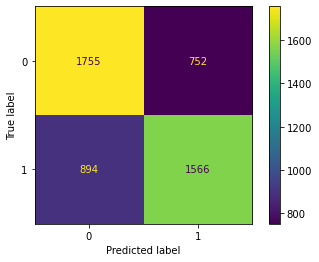

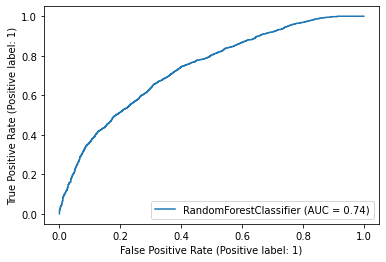

In [113]:
print('The best score produced by hyperparameter tuning is',rf.best_score_)
print('The optimal paramters are ',rf.best_params_)
print(classification_report(y_test, rf.best_estimator_.predict(X_test)))
plot_confusion_matrix(rf.best_estimator_, X_test, y_test)
plot_roc_curve(rf.best_estimator_,X_test,y_test)

### Logistic Regression

In [114]:
lr_parameters = {'penalty':['l1','l2','elasticnet'],'C':[0.01,0.1,1,10,100],'solver':['saga','liblinear']}
lr = GridSearchCV(LogisticRegression(),param_grid = lr_parameters, cv = 5)
lr.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linea

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga', 'liblinear']})

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


The best score produced by hyperparameter tuning is 0.6516329081389971
The optimal paramters are  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      2507
           1       0.64      0.70      0.67      2460

    accuracy                           0.66      4967
   macro avg       0.66      0.66      0.66      4967
weighted avg       0.66      0.66      0.66      4967



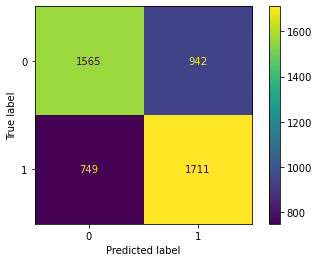

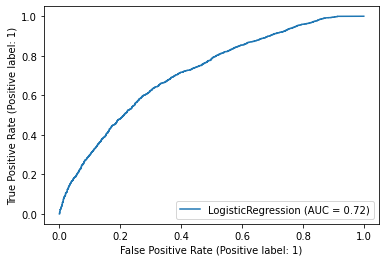

In [115]:
print('The best score produced by hyperparameter tuning is',lr.best_score_)
print('The optimal paramters are ',lr.best_params_)
print(classification_report(y_test, lr.best_estimator_.predict(X_test)))
plot_confusion_matrix(lr.best_estimator_, X_test, y_test)
plot_roc_curve(lr.best_estimator_,X_test,y_test)

### Decision Tree Classifier

In [116]:
dtc_parameters = {'criterion':['gini','entropy'], 'splitter':['best','random'],}
dtc = GridSearchCV(DecisionTreeClassifier(), param_grid = dtc_parameters, cv = 5)
dtc.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'splitter': ['best', 'random']})

The best score produced by hyperparameter tuning is 0.6268683011434378
The optimal paramters are  {'criterion': 'entropy', 'splitter': 'random'}
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      2507
           1       0.63      0.65      0.64      2460

    accuracy                           0.64      4967
   macro avg       0.64      0.64      0.64      4967
weighted avg       0.64      0.64      0.64      4967



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


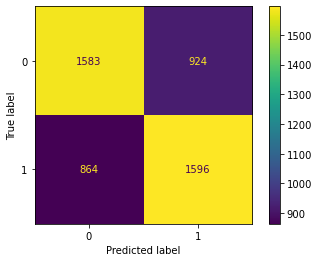

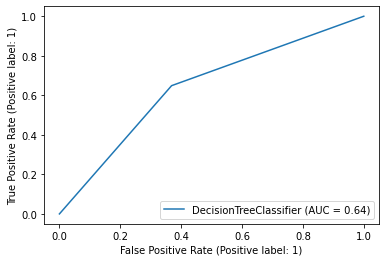

In [117]:
print('The best score produced by hyperparameter tuning is',dtc.best_score_)
print('The optimal paramters are ',dtc.best_params_)
print(classification_report(y_test, dtc.best_estimator_.predict(X_test)))
plot_confusion_matrix(dtc.best_estimator_, X_test, y_test)
plot_roc_curve(dtc.best_estimator_,X_test,y_test)

### KNN Classifier

In [121]:
knn_parameters = {'n_neighbors':[3,4,5],'weights': ['uniform','distance']}
knn = GridSearchCV(KNeighborsClassifier(), param_grid = knn_parameters, cv = 5)
knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5],
                         'weights': ['uniform', 'distance']})

The best score produced by hyperparameter tuning is 0.6206272814573357
The optimal paramters are  {'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      2507
           1       0.62      0.65      0.64      2460

    accuracy                           0.63      4967
   macro avg       0.63      0.63      0.63      4967
weighted avg       0.63      0.63      0.63      4967



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


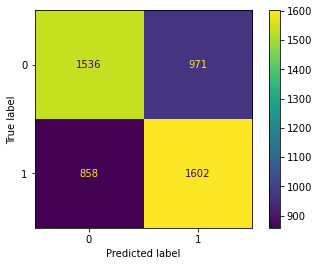

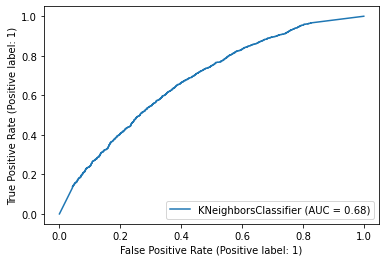

In [122]:
print('The best score produced by hyperparameter tuning is',knn.best_score_)
print('The optimal paramters are ',knn.best_params_)
print(classification_report(y_test, knn.best_estimator_.predict(X_test)))
plot_confusion_matrix(knn.best_estimator_, X_test, y_test)
plot_roc_curve(knn.best_estimator_,X_test,y_test)

### Support Vector Classifier

In [123]:
svc = SVC()
svc.fit(X_train,y_train)

SVC()

The best score produced by hyperparameter tuning is 0.6736460640225488
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      2507
           1       0.67      0.68      0.67      2460

    accuracy                           0.67      4967
   macro avg       0.67      0.67      0.67      4967
weighted avg       0.67      0.67      0.67      4967



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


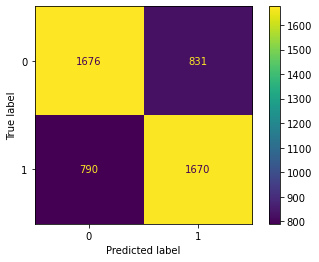

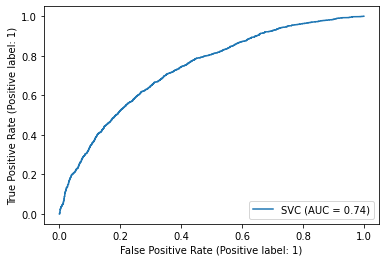

In [124]:
print('The best score produced by hyperparameter tuning is',svc.score(X_test,y_test))
print(classification_report(y_test, svc.predict(X_test)))
plot_confusion_matrix(svc, X_test, y_test)
plot_roc_curve(svc,X_test,y_test)

## AdaBoosting Classifier

In [127]:
ad_params = {'n_estimators':[50,100,150,200,250], 'algorithm':['SAMME','SAMME.R']}
ad = GridSearchCV(AdaBoostClassifier(), param_grid = ad_params, cv = 5)
ad.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'n_estimators': [50, 100, 150, 200, 250]})

The best score produced by hyperparameter tuning is 0.7056573384336622
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      2507
           1       0.69      0.74      0.71      2460

    accuracy                           0.71      4967
   macro avg       0.71      0.71      0.71      4967
weighted avg       0.71      0.71      0.71      4967



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


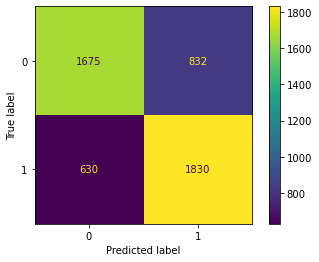

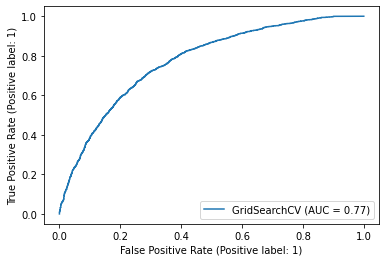

In [128]:
print('The best score produced by hyperparameter tuning is',ad.score(X_test,y_test))
print(classification_report(y_test, ad.predict(X_test)))
plot_confusion_matrix(ad, X_test, y_test)
plot_roc_curve(ad,X_test,y_test)

## GradientBoosting Classifier

In [129]:
gb_params = {'n_estimators': [50,100,150,200,250], 'min_samples_leaf': [1,3,5,7,9], 'max_depth':[3,4,5]}
gb = GridSearchCV(GradientBoostingClassifier(),param_grid = gb_params, cv = 5)
gb.fit(X_train,y_train)  

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [3, 4, 5],
                         'min_samples_leaf': [1, 3, 5, 7, 9],
                         'n_estimators': [50, 100, 150, 200, 250]})

The best score produced by hyperparameter tuning is 0.739883229313469
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2507
           1       0.73      0.75      0.74      2460

    accuracy                           0.74      4967
   macro avg       0.74      0.74      0.74      4967
weighted avg       0.74      0.74      0.74      4967



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


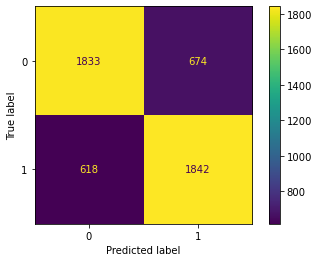

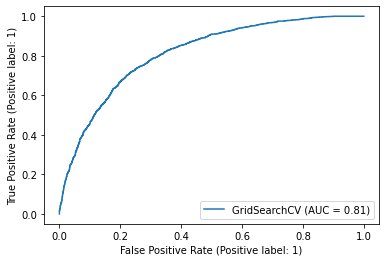

In [130]:
print('The best score produced by hyperparameter tuning is',gb.score(X_test,y_test))
print(classification_report(y_test, gb.predict(X_test)))
plot_confusion_matrix(gb, X_test, y_test)
plot_roc_curve(gb,X_test,y_test)

### Selecting the best Model
There are many evaluation metrics that can be used to select and review a model. In the case of this dataset, there is one metric that is extremely important,
* Type 2 error (False Negative) : This is where the true label is Fraudulant Transaction but the model has predicted Non Fraudulant which can be very dangerous as the transaction might go unnoticed until the customer reviews his statement.
#### Gradient Boosting Classifier has produced the best model based on its comparatively lowest False Negatives and highest AUC score

### Things to explore

With more time, money and computational power the models can be built be fairly more complex and accurate but here are some points that would be an immediate improvement with more computational power,
* Tomek Links oversampling : Both the oversampling and the hyperparameter tuning and training requires high computational power and training time.
* XGBoost : I was not able to implement the XGBoost due to some technical limitations and if given some more time I am sure that I could have been able to train the model using this algorithm.